<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/7_tfidf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.utils import (
    calendar_table,
    visualize_term_counter,
    enable_mathjax_in_cell,
    plot_confusion_matrix,
    show_vectorizer_largest_components,
    display_cv_results,
)
from tmcourse.ipyquiz import Quiz, Function
from tmcourse.quiz import (
    quiz_tfidf,
    quiz_kmeans,
    quiz_estimate_clustering_quality,
)

from tmcourse.demo import (
    demo_kmeans,
)

from collections import Counter, defaultdict
from math import exp
from tabulate import tabulate
from pprint import pprint
from tqdm.notebook import tqdm
from IPython.display import HTML, display
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import glob

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Updating files: 100% (129/129), done.


<!--@slideshow slide-->
<h1><center>TF-IDF. Text classification.</center></h1>

<!--@slideshow slide-->
# Dataset: Elon Musk tweets 2010-2021

In this lesson, we will study [Elon Musk tweets](https://www.kaggle.com/ayhmrba/elon-musk-tweets-2010-2021) stored in CSV files in [the course repo on GitHub](https://github.com/horoshenkih/harbour-space-text-mining-course).


In [ ]:
#@slideshow fragment
import glob

dataset_files = glob.glob("harbour-space-text-mining-course/datasets/musk/*.csv")
dfs = [pd.read_csv(f) for f in dataset_files]
df = pd.concat(dfs, axis=0, ignore_index=True)

<!--@slideshow slide-->
# "Words of a day"

**Problem statement**

For each day, find words which are "specific" for this day in Musk tweets.


<!--@slideshow fragment-->
**Definitions and notation**:
- *Term* (notation: $t$) is a "meaningful" piece of text (lemma in our case).
- *Document* (notation: $d$) is the collection of tweets created on a given day.
- $D$ is the set of all documents (not tweets!).

<!--@slideshow slide-->
The first attempt: find the most frequent term for each document.

In [ ]:
#@slideshow fragment tags=remove_input
from dateutil.parser import parse as parse_datetime  # convert a string in any format to a datetime object
# preprocess the data: convert each tweet into a tuple (date, lemmas_list)

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tok2vec"])

def extract_lemmas(r):
    # take the specifics of tweets into account: ignore tokens which represent https://t.co/... hyperlinks
    return [
        token.lemma_
        for token in nlp(r['tweet'])
        if not token.lemma_.startswith('https://t.co')
    ]

df['tweet_date'] = df.apply(lambda r: parse_datetime(r['date']).date(), axis=1)
df['tweet_lemmas'] = df.apply(extract_lemmas, axis=1)
preprocessed_tweets = [
    (r['tweet_date'], r['tweet_lemmas'])
    for _, r in
    df.reset_index().iterrows()
]

# this is how the preprocessed data looks like
print("preprocessed_tweets = ")
pprint(preprocessed_tweets[:3], compact=True)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


preprocessed_tweets = 
[(datetime.date(2012, 12, 25),
  ['@karlschroeder', 'interesting', 'premise', '.', 'i', 'will', 'read', 'it',
   '.']),
 (datetime.date(2012, 12, 25),
  ['@tristanlaurent', 'v', 'cute', '!', 'merry', 'xmas', '.']),
 (datetime.date(2012, 12, 24),
  ['cowboy', 'riding', 'the', 'rocket', 'no', 'problemo', ' ',
   'http://t.co/yzdnpwx3'])]


In [ ]:
NUM_WORDS_OF_A_DAY = 5  # how many words 'describe' a day

In [ ]:
#@slideshow slide
# term count for each document
document_term_counter = defaultdict(Counter)
for tweet_date, tweet_lemmas in tqdm(preprocessed_tweets):
    for lemma in tweet_lemmas:
        # tweet_date is the document
        # lemma is the term
        document_term_counter[tweet_date][lemma] += 1

  0%|          | 0/43074 [00:00<?, ?it/s]

In [ ]:
#@slideshow fragment tags=remove_input
# visualize

documents = []
terms = []
weights = []

for d in sorted(document_term_counter):
    documents.append(d)
    # get the most frequent terms and their count
    term_counts = document_term_counter[d].most_common(NUM_WORDS_OF_A_DAY)
    total_weight = sum(_[1] for _ in term_counts)
    terms.append(" ".join(_[0] for _ in term_counts))
    weights.append(total_weight)

html = calendar_table(documents, terms, weights, from_datetime=date(2020, 3, 30))
display(HTML(html))

week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2020-03-30 - 2020-04-05,for @ian1219 ok @renatakonkoly,". , be will the",", @kimitalvitie . need wider",". @thirdrowtesla , @28delayslater to",". to @thirdrowtesla , &",@28delayslater @thirdrowtesla . @teslaownerssv,". , the in is"
2020-04-06 - 2020-04-12,@thirdrowtesla 🤣 @morgan_murphy a not,@johnkrausphotos @erdayastronaut & amp ;,@thirdrowtesla in a . @flcnhvy,@thirdrowtesla @rationaletienne @sofiaan @icannot_enough @hein_the_slayer,to for but . @cleantechnica,". , is a the",. the for @livingtesla @tesla
2020-04-13 - 2020-04-19,", @thirdrowtesla will just .",will giga berlin it ’s,"to be , clear fremont",". , is @erdayastronaut @sciguyspace",". , & amp ;",". , ! the @erdayastronaut",". , is the @erdayastronaut"
2020-04-20 - 2020-04-26,! @kristennetten @thirdrowtesla @tesla i,"on @ppathole @anniew the ,",". @thirdrowtesla @mfrunker , @supernova_style",", . @teslaownerssv is &",to 🤣 is @tesla .,". is to be ,",. of is @nasaspaceflight a
2020-04-27 - 2020-05-03,is ! to . of,@redtheraider @tedhu @officialmcafee 💯,"! yes , @skorusark",is this ! to,the . is to on,@grimezsz the @thirdrowtesla 🤣 @biogirl09,", a . ? that"
2020-05-04 - 2020-05-10,. ! @blazingtorchic _ is,. a @priscillabanana @alexberenson @neil_ferguson,"@grimezsz ! , the .",". , the a @erdayastronaut",", the . to @mayemusk",", . @thirdrowtesla @gerberkawasaki the",", to @rbreich they @legendaryenergy"
2020-05-11 - 2020-05-17,". , is ! @thirdrowtesla",". , a that !",of is @sciguyspace ! heavy,exactly @jpr007 @alexberenson @nytimes,". the , is in",,@jeff_foust @bluemoondance74 . & amp
2020-05-18 - 2020-05-24,. the to a fsd,! cancel 🤣 @rationaletienne i,@flcnhvy true,@janeidyeve sure @hackclub cool group,@spacex @whatsupfranks of to new,. to is be a,🤣 @jimkwik @jadescipioni @theonion a
2020-05-25 - 2020-05-31,. @virgin_orbit sorry to hear,! @realclearnews @samtalkstesla @rationaletienne,@sciguyspace he is great,,", . @vincent13031925 to !","to , risk 5 mins","@spacex @nasa @space_station @nasaspaceflight ,"
2020-06-01 - 2020-06-07,the to officers does ?,off twitter for a while,,. is to years !,. @flcnhvy @jbw29pitt @ppathole @nasaspaceflight,"the in , a",@nasaspaceflight . @erdayastronaut of @flcnhvy


<!--@slideshow slide-->
- As expected, the most frequent terms overall are the most frequent in each document.
- The most frequent terms are not informative
- Does informativity depend on frequency?

In [ ]:
# count all terms
term_counter = Counter()
for tweet_date, tweet_lemmas in preprocessed_tweets:
    for term in tweet_lemmas:
        term_counter[term] += 1

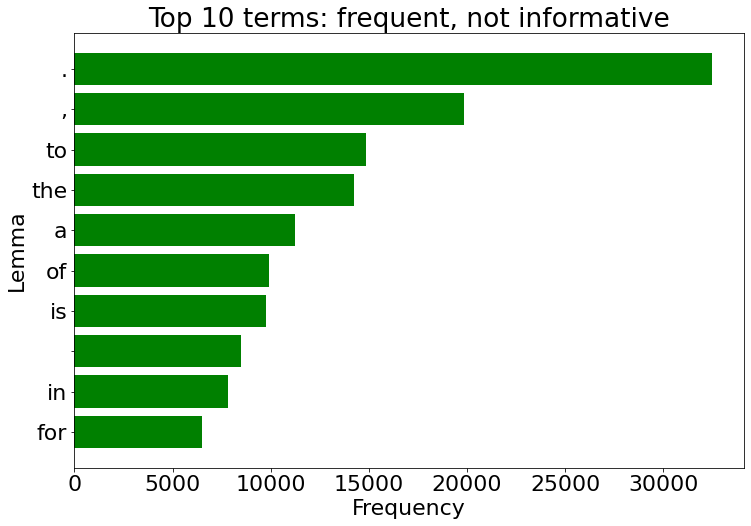

In [ ]:
#@slideshow slide tags=remove_input
visualize_term_counter(term_counter, 0, "Top 10 terms: frequent, not informative", use_ggplot=False)

In [ ]:
len(term_counter)

18460

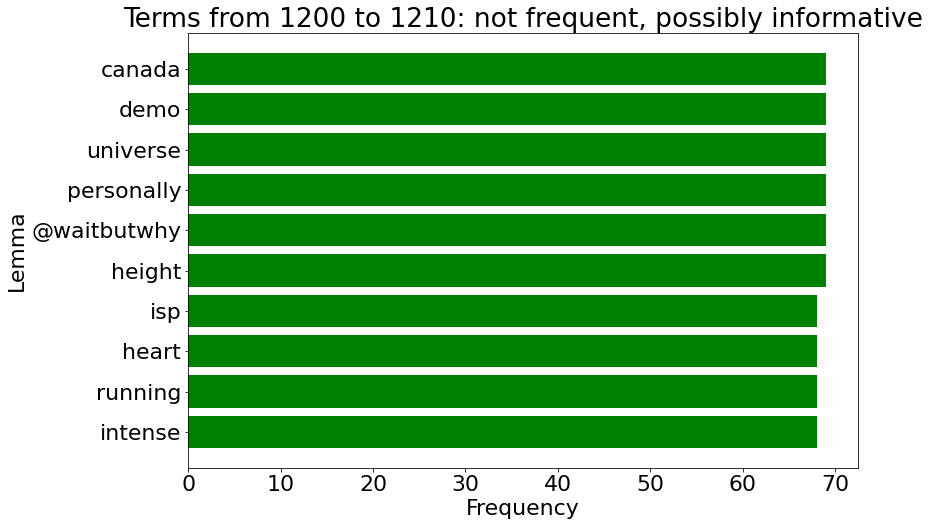

In [ ]:
#@slideshow slide tags=remove_input
shift = 1200
visualize_term_counter(term_counter, shift, f"Terms from {shift} to {shift+10}: not frequent, possibly informative", use_ggplot=False)

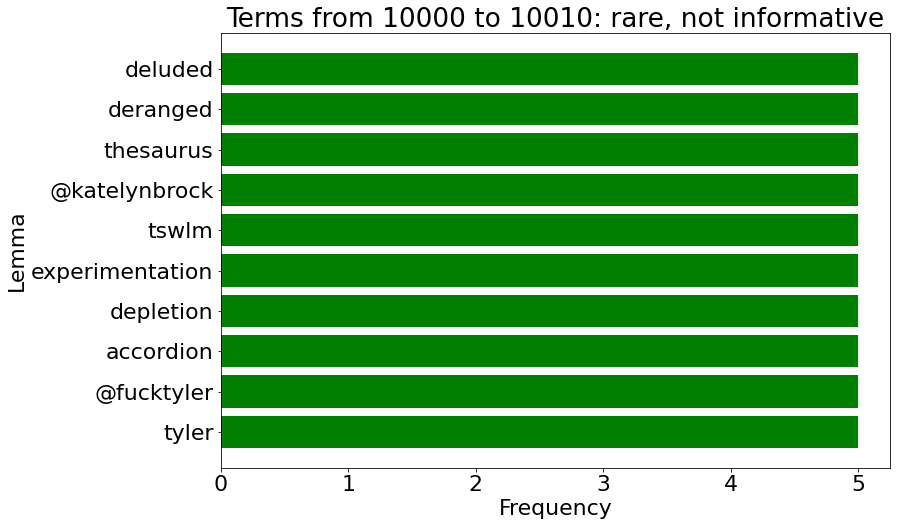

In [ ]:
#@slideshow slide tags=remove_input
shift = 10000
visualize_term_counter(term_counter, shift, f"Terms from {shift} to {shift+10}: rare, not informative", use_ggplot=False)

<!--@slideshow slide-->
# TF-IDF

Try the following idea:
> The term $t$ is specific (or informative) for the document $d$ if it is relatively rare in $D$ but frequent in $d$.

<!--@slideshow fragment-->

The measure of "informativity" of term $t$ for document $d$ should satisfy two properties:
1. The higher the frequency of $t$ in $d$, the _higher_ the informativity.
2. The higher the frequency of $t$ in the collection $D$, the _lower_ the informativity.





<!--@slideshow fragment-->
It can be written as the product of two functions:
$$TFIDF(t, d, D) = TF(t, d) \cdot IDF(t, D)$$

<!--@slideshow slide-->
## Term frequency $TF(t, d)$

Term frequency is just the number of occurrences of the term $t$ in the document $d$.

<!--@slideshow slide-->
## Inverse document frequency $IDF(t, D)$

- In practice, the range of "informativity" is wide.
- Informative terms may occur in 1%, 0.1% or even 0.01% of all documents $D$.
- That's why $IDF(t, D)$ depends on $t$'s frequency in $D$ _logarithmically_.
> If $t_1$ is 10 times more frequent than $t_2$, then $IDF(t_1, D) - IDF(t_2, D) = \mathrm{const}$

<!--@slideshow slide-->
$IDF(t, D)$ is computed in 3 steps:
1. Compute the number of documents that contain $t$.
2. Divide it by the total number of documents.
  > The result is the probability to find term $t$ in a randomly chosen document.
3. Take the $\log$ of the _inverse_ quantity from the previous step.


<!--@slideshow fragment-->
Or, mathematically
$$
IDF(t, D) = \log\left(\dfrac{|D|}{|\{d \in D | t \in d\}|}\right)
$$
- $|D|$ is the total number of documents
- $|\{d \in D | t \in d\}|$ is the number of documents that contain $t$

<!--@slideshow slide-->
## TF-IDF example

Consider the collection $D$ containing 3 documents

1. $d_1$ = "If you tell the truth you don’t have to remember anything."
2. $d_2$ = "If you don’t read the newspaper, you’re uninformed. If you read the newspaper, you’re misinformed."
3. $d_3$ = "A lie can travel half way around the world while the truth is putting on its shoes."

Let us compute $TFIDF(\mathrm{''newspaper''}, d_2, D)$:
- $TF(\mathrm{''newspaper''}, d_2) = 2$
- $IDF(\mathrm{''newspaper''}, D) = \log\left(\dfrac{3}{1}\right) \approx 1.1$
- $TFIDF(\mathrm{''newspaper''}, d_2, D) \approx 2.2$

<!--@slideshow slide-->
## Colab quiz 1
Compute $TFIDF(\mathrm{''If''}, d_1, D)$




In [ ]:
enable_mathjax_in_cell()
quiz_tfidf()()

<!--@slideshow slide-->
## TF-IDF implementation

In [ ]:
#@slideshow fragment
from collections import defaultdict, Counter
# 1. Compute IDF for all terms.
#    Remember that we've already computed term counts for all documents.
#    Document_term_counter[document][term] = term_count_in_document.

# For each term, compute the number of documents where the term occurs
term_counter = Counter()
for document in document_term_counter:
    for term in document_term_counter[document]:
        term_counter[term] += 1
# compute term IDFs from term counts
num_documents = len(document_term_counter)
from math import log
term_idf = {
    term: log(num_documents / term_count)
    for term, term_count in term_counter.items()
}

# 2. Compute TF-IDF for all terms and documents
document_term_tfidf = defaultdict(Counter)
for document in document_term_counter:
    word_tfidf = {}
    for term in document_term_counter[document]:
        tf = document_term_counter[document][term]
        idf = term_idf[term]
        document_term_tfidf[document][term] = tf * idf

In [ ]:
# visualize
documents = []
terms = []
weights = []

for d in sorted(document_term_tfidf):
    documents.append(d)
    # get the most frequent term and its count
    top_terms = list(
        sorted(document_term_tfidf[d], key=lambda t: document_term_tfidf[d][t], reverse=True)
    )[:NUM_WORDS_OF_A_DAY]
    terms.append(" ".join(top_terms))
    weights.append(sum(document_term_tfidf[d][t] for t in top_terms))

def print_tweets_by_date(tweets_df, date_of_tweets):
    from pprint import pprint
    # ignore retweets
    for _, r in tweets_df[tweets_df.tweet_date == date_of_tweets].reset_index().iterrows():
        pprint(r["tweet"])
        print("---")

<!--@slideshow slide-->
## Colab demo: insights from daily TF-IDF

In [ ]:
# price of which cryptocurrency increased the most between 2021-02-01 and 2021-02-14?
html = calendar_table(
    documents,
    terms,
    weights,
    from_datetime=date(2021, 2, 1),
    to_datetime=date(2021, 2, 14),
)
display(HTML(html))

week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2021-02-01 - 2021-02-07,graffiti @eiraum сделаем @hamoon implant,twitter while off for a,,shut @erdayastronaut engines doge @ajtourville,@josh_bickett @ajtourville fed isp @erdayastronaut,@astrojordy @grimezsz emails texts @dumdin7,@dogecoinrich 🎶 🤣 @nivetha_7_42 hodl
2021-02-08 - 2021-02-14,@michaelhodapp doge @capybarasurfer inflationary meaningfully,@adamklotz _ starlink @rationaletienne cash,@freewalletorg @givedirectly @geoffkeighley @unrealengine toddler,@anonyx10 @gtera27 underdoge himself @spotify,@kunalb11 ray hdr @dixonspace tracing,было бы большой честью поговорить,concentrated coins concentration percentage holders


In [ ]:
print_tweets_by_date(df, date(2021, 2, 7))

'@Nivetha_7_42 @lexfridman So cute 💕'
---
('@UniverCurious Extremely misleading image, as doesn’t reflect true time cost '
 'to people or rain &amp; pain')
---
'🎶 Who let the Doge out 🎶'
---
'Hodl the rainforests!!'
---
'So … it’s finally come to this …  https://t.co/Gf0Rg2QOaF'
---
'@itsALLrisky It’s the most fun crypto!'
---
'@JoshRoomsburg @SnoopDogg @genesimmons Its simplicity is its genius'
---
'@astro_g_dogg @SpaceX Yup'
---
'@Jbuttermost @Dogecoinrich 🤣🤣'
---
'@wapodavenport True'
---
'@Dogecoinrich 🤣🤣'
---


In [ ]:
# look at the period of the first COVID-19 outbreak in the US
from datetime import date
html = calendar_table(
    documents,
    terms,
    weights,
    from_datetime=date(2020, 3, 1),
    to_datetime=date(2020, 5, 1),
)
display(HTML(html))

week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2020-03-02 - 2020-03-08,@realemirhan puck shuck labelling @janeidyeve,@jack pressurize sleeving bernie 0.2,catalog @sofiaan fsd committees complained,heights raising art new @tesla,coronavirus panic dumb is the,envelope tonight @cosmicdatabase land expanded,@fxzzonthebeat extrapolating overstated symptoms c19
2020-03-09 - 2020-03-15,flights @yunli626 thrust correction puck,@coachella @balabushkafury @autozeitung woofers @_sear,@janeidyeve @neiltyson war thank @poisontoxic21,triassic permian @thingswork bad super,,@ianpavelko @bensullins @eugenelee3 @bhmoors @teslatunity,killer fear ny mind congratulations
2020-03-16 - 2020-03-22,@meckimac chloroquine misdiagnosed @renatakonkoly stanford,corona danger sensible maladies @mikefthomp,@sciguyspace fear n’t yeah @kmastersbarnes,cases @ppathole ventilators close @natesilver538,@moskov ventilators @friedberg @mg42bonesaw personalize,@natesilver538 containment positive asymptote sigmoidal,ppe @benikbeno @cdcgov getting death
2020-03-23 - 2020-03-29,@jonkay @quillette @sdunbabin masks @thirdrowtesla,@mikebloomberg @stephenpallotta @ajtourville @thirdrowtesla @jordanwells33,@flcnhvy york c19 cases @tesla,@alexberenson medtronic ny @brianswails @imperialcollege,@nycmayor ventilators @vitalvegas blood them,@abbottnews @microdentist @n2179_twit receiving treating,
2020-03-30 - 2020-04-05,@ian1219 logarithm personality graphs substitute,~150 warehouse telescope @marsmeditation @rationaletienne,@kimitalvitie span wider upgrades @pinkshotgun1,@thirdrowtesla @drdavidreich @28delayslater intratracheal severe,@brandonbernicky @thirdrowtesla @johncleese @labpadre @kristennetten,@28delayslater @thirdrowtesla medtronic @teslaownerssv @henryfordnews,@labpadre @austinbarnard45 @ppathole @wjduncan pressure
2020-04-06 - 2020-04-12,@morgan_murphy @thirdrowtesla 🤣 @ndrew_lawrence puts,@johnkrausphotos fall @thirdrowtesla @forumtesla @rknapp_12,@thirdrowtesla trillion cameras often second,@hein_the_slayer @rmattila74 @mowo91 @icannot_enough @kimbal,@jamie_woodward downtown realistic @arvnp predictions,@zvezdichko @katlinegrey @sciguyspace expendable strange,@livingtesla @reallifestarman vandalism monitoring spying
2020-04-13 - 2020-04-19,@thirdrowtesla powertrain cheetahs stolen q&a.,berlin giga subtly curvature wrap,retrofit shop shanghai fremont upgraded,@imatsb @some1gee @cnn @sciguyspace @thesheetztweetz,@dwesterster strakes cfd @covellomassimo sparingly,@dwesterster @michaelcanary02 @af_academy @austeslaowners @erdayastronaut,invasive * covid @erdayastronaut platform
2020-04-20 - 2020-04-26,@thirdrowtesla @kristennetten @tobyliiiiiiiiii 🤓 @batflyer,@anniew @morgan_murphy flaps dusk @cleantechnica,@mfrunker @supernova_style @anime_virus @thirdrowtesla invasive,@togregto @josephvvallace @codingmark @teslaownerssv @thirdrowtesla,@vencikudev 🤣 press machine @thirdrowtesla,@alexanderbittan @shelbiestrykers @cbsnewyork @aiellotv @justpaulinelol,@nasaspaceflight @cardoso 🔥 .@officialmcafee ductility
2020-04-27 - 2020-05-03,@janeidyeve covid @harrystoltz1 @ethicalskeptic @legendaryenergy,@redtheraider @officialmcafee @tedhu 💯,@randyfineto bon voyage @therightmelissa arrest,corona sensible @jamesokeefeiii classifying @way2_savage,freedom @bitcoin @alfzeta @ap4liberty rage,,


In [ ]:
print_tweets_by_date(df, date(2020, 3, 19))

'@DOfaquarius @PPathole Thanks 💖'
---
('@Cernovich China is operating normally across hundreds of suppliers &amp; '
 'all of Tesla Shanghai')
---
('@DOfaquarius @PPathole We’re working on ventilators, even though I think '
 'there will not be a shortage by the time we can make enough to matter')
---
('@flcnhvy Anyone feeling even slightly ill should stay home. Elderly should '
 'avoid close contact, even with family members, for now. Those seem most '
 'important.')
---
'@RationalEtienne @PPathole  https://t.co/eltgA3hrAr'
---
('@RationalEtienne @PPathole Kids are essentially immune, but elderly with '
 'existing conditions are vulnerable. Family gatherings with close contact '
 'between kids &amp; grandparents probably most risky.')
---
('@PPathole Based on current trends, probably close to zero new cases in US '
 'too by end of April')
---
'@PPathole Yes'
---
'No new domestic corona cases in China  https://t.co/lGmxRvMyFy'
---
('@westcoastbill Imo, this professor is correct. Also, gr

In [ ]:
# how many hype trends can you find in 3 weeks of tweets?
from datetime import date
html = calendar_table(
    documents,
    terms,
    weights,
    from_datetime=date(2021, 3, 1),
    to_datetime=date(2021, 3, 21),
)
display(HTML(html))

week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2021-03-01 - 2021-03-07,@wholemarsblog spac @totalspace360 legendary regretamine,thence @wootieztv @pslavi @draecomino starbase,@labpadre @f9block5 @larry_in_canada @billhuang688 @ppathole,sn10 @skorusark commonplace excruciating honorable,fantasy 🙄 valhalla cybervikings underestimated,@timsweeneyepic beta q2 internally qa,band broke bad m up
2021-03-08 - 2021-03-14,rvs @harbles @klenderjoey @klwtts carnot,@wholemarsblog download qa helium header,@nasaspaceflight aircraft @tobyliiiiiiiiii liquid gamechanger,@arstechnica @sciguyspace @trevormahlmann @spacepadreisle payload,@thejackbeyer beta immunocompromised jab reactions,doge afternoon 🎶 dogematic appease,fly @____amir pretties puckish rogue
2021-03-15 - 2021-03-21,@beeple nfts nft 2x 420,selling pass feel quite does,sn11 @rjdlandscapes cgi irl @erdayastronaut,booster @lexfridman hook ~140 struggled,@jordanbpeterson @thejackbeyer talk преступленіе наказаніе,@twittercomms 8.x @verified ate sandwich,slows introduction @swaggerheim roast @atomicsastro


<!--@slideshow slide-->
The idea of TF-IDF is very general and can be applied not only for texts.
  > For example, a sequence of websites visited by a user can be treated as a "document", and each individual website is a "term".

  > It doesn't tell you much if the user visits [facebook.com](https://colab.research.google.com/drive/1HBWC4XPaYmnyF8nF6OpAKSy1hLasZxuV?usp=sharing) 10 times a day.
  
  > But 10 visits of [stackoverflow.com](https://stackoverflow.com) per day may tell you something.


<!--@slideshow slide-->
## Probabilistic interpretation of TF-IDF



<!--@slideshow slide-->
Given the collection of documents $D$, for each $d \in D$ we want to figure out which terms are the most specific for the document.

Let the number of terms is finite: $T$ distinct terms.



<!--@slideshow fragment-->
Let $p_t$ is the probability to find the term $t$ in a random document from $D$, and $f_t$ is the frequency of term $t$ in the document $d$ ($f_t$ may be 0).



<!--@slideshow fragment-->
Then the product $\prod_{t=1}^{T} p_i^{f_t}$ gives the probability that the document $d$ is generated randomly.



<!--@slideshow fragment-->
Thus, the inverse quality $L_d = \prod_{t=1}^{T} p_t^{-f_t}$ shows "non-randomness" of the document $d$



<!--@slideshow fragment-->
Take the $\log$:
$$
\log L_d = \sum_{t=1}^{T}f_t\log\left(\frac{1}{p_t}\right)
$$
The higher the $t$-th summand, the more the term $t$ makes the document "non-random".



<!--@slideshow fragment-->
Note that $t_i\log\left(\frac{1}{p_t}\right) = TFIDF(t, d)$.

# TF-IDF in sklearn

<!--@slideshow slide-->
# Transform texts to vectors

In practice, it's convenient to have the finite number of terms.
> We can use, say, 10000 the most common words, ignoring all the other words.

In [ ]:
#@slideshow slide tags=remove_input
n_frequent_terms = 10000
most_common_terms = set([x[0] for x in term_counter.most_common()][:n_frequent_terms])
import random
random.seed(42)

tweets_data = []
for random_tweet in random.choices(preprocessed_tweets, k=10):
    original_tweet = " ".join(random_tweet[1])
    masked_tweet = []
    for t in random_tweet[1]:
        if t in most_common_terms:
            masked_tweet.append(t)
        else:
            masked_tweet.append("<UNK>")
    tweet_with_rare_words_ignored = " ".join(masked_tweet)
    tweets_data.append((original_tweet, tweet_with_rare_words_ignored))

from IPython.display import display, HTML
display(HTML(tabulate(
    tweets_data,
    headers=(
        "Original tweets ({} terms)".format(len(term_counter)),
        "Keep {} frequent terms".format(n_frequent_terms)
    ),
    tablefmt="html"
)))

Original tweets (18460 terms),Keep 10000 frequent terms
@jeremyheitman sentience is overrated,<UNK> sentience is overrated
t minus 10 minutes ... entering terminal count # dragonlaunch,t minus 10 minutes ... entering terminal count # dragonlaunch
@redmor11 @schristakos @jgrano305 @dmc_ryan will recognize & amp ; read all signs for fsd . focused on traffic lights & amp ; stop signs right now . most are very easy . difficulty is millions of corner cases .,@redmor11 @schristakos @jgrano305 @dmc_ryan will recognize & amp ; read all signs for fsd . focused on traffic lights & amp ; stop signs right now . most are very easy . difficulty is millions of corner cases .
hospitals in california have been half empty this whole time,hospitals in california have been half empty this whole time
gave a talk on energy and transport at oxford univ http://t.co/kbvjf5lo,gave a talk on energy and transport at oxford univ http://t.co/kbvjf5lo
this is going to be great,this is going to be great
@nichegamer it ’s almost done,@nichegamer it ’s almost done
"upcoming falcon 9 demo has a lot of new technology , so the probability of failure is significant http://t.co/pfngeeaawq","upcoming falcon 9 demo has a lot of new technology , so the probability of failure is significant http://t.co/pfngeeaawq"
falcon 9 flight 11 to geosynchronous transfer orbit completed on target this morning http://t.co/uojmnohtur,falcon 9 flight 11 to geosynchronous transfer orbit completed on target this morning http://t.co/uojmnohtur
@clickhole hate it when that happens . some people are so rude !,@clickhole hate it when that happens . some people are so rude !


<!--@slideshow slide-->
Our observations so far:
1. For each term $t$ in each document $d \in D$, we can compute $TFIDF(t, d, D)$.
2. We can have the finite number of terms.

Therefore, we can represent each document with the fixed set of TFIDFs.

<!--@slideshow fragment-->
In other words, we can convert a document into a **vector**.

<!--@slideshow fragment-->
But why?
- To compute the distance between two documents (for example, to find similar documents).
- Vectors are inputs for machine learning algorithms.

<!--@slideshow slide-->
scikit-learn implements so-called "vectorizers" that convert texts into vectors.

In [ ]:
#@slideshow fragment
# TfidfVectorizer converts texts into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# the texts we will vectorize
data = [
  "One, two, three.",
  "Two, three.",
  "Three."
]

# Tfidf vectorizer has the "smooth" version of IDF
# Here is the difference:
#   idf = log(n_documents / count) + 1
#   smooth_idf = log((n_documents + 1) / (count + 1)) + 1

# Note that instead of 
#   idf = log(n_documents / count)
# TfidfVectorizer computes
#   idf = log(n_documents / count) + 1
# It helps to distinguish 2 cases:
#   1. TF-IDF(t, d, D) = 0 because the term t is absent in the document d
#   2. TF-IDF(t, d, D) = 0 because the term t is present in each document in the collection D
vectorizer = TfidfVectorizer(smooth_idf=False)

# to compute TF-IDFs, use the method `.fit()`
vectorizer.fit(data)

TfidfVectorizer(smooth_idf=False)

In [ ]:
#@slideshow slide
# vectorizer.vocabulary_ contains word -> index mapping
print("vectorizer.vocabulary_:", vectorizer.vocabulary_)
# vectorizer.idf_ contains the idf value for each index
print("vectorizer.idf_:", vectorizer.idf_)

# let's check that TfidfVectorizer uses the formula
#   idf = log(n_documents / count) + 1
# to do so, we restore word count from idf
vectorizer_internals = []
for word, idx in vectorizer.vocabulary_.items():
  idf = vectorizer.idf_[idx]
  n_documents = len(data)
  count = n_documents / exp(idf - 1)
  vectorizer_internals.append([word, idf, count])

print(tabulate(vectorizer_internals, headers=["word", "idf", "count"]))

vectorizer.vocabulary_: {'one': 0, 'two': 2, 'three': 1}
vectorizer.idf_: [2.09861229 1.         1.40546511]
word        idf    count
------  -------  -------
one     2.09861        1
two     1.40547        2
three   1              3


In [ ]:
#@slideshow slide
# The trained vectorizer can be applied on new data
new_data = [
    "Two, three, four",
    "Five",
]
pprint(vectorizer.transform(new_data).todense())

matrix([[0.        , 0.57973867, 0.81480247],
        [0.        , 0.        , 0.        ]])


<!--@slideshow fragment-->
The `.transform()` method converts the input text array into matrix where:
- $i$-th row corresponds to the $i$-th input text
- $j$-th column corresponds to some term $t_j$ *from the training set*
  > The mapping $t_j \rightarrow j$ is stored in the `.vocabulary_` attribute.

Note that:
1. New words ("four", "five") are ignored.
1. Non-zero vectors are normalized (have length 1).

<!--@slideshow slide-->
By default, `TfidfVectorizer` performs simple tokenization: lowercasing, split by punctuation.

In [ ]:
#@slideshow fragment
text = df.tweet[99]
print(text)
vectorizer = TfidfVectorizer().fit([text])
print(vectorizer.vocabulary_)

Olympics opening is excellently British. Jolly good show!  http://t.co/s9XZdaBL
{'olympics': 7, 'opening': 8, 'is': 5, 'excellently': 2, 'british': 0, 'jolly': 6, 'good': 3, 'show': 10, 'http': 4, 'co': 1, 's9xzdabl': 9}


<!--@slideshow fragment-->
But the tokenizer can be redefined:

In [ ]:
#@slideshow fragment
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tok2vec"])

def spacy_tokenizer(text):
    return [t.lemma_ for t in nlp(text)]

text = df.tweet[99]
print(text)
vectorizer_spacy = TfidfVectorizer(tokenizer=spacy_tokenizer).fit([text])
print(vectorizer_spacy.vocabulary_)

Olympics opening is excellently British. Jolly good show!  http://t.co/s9XZdaBL
{'olympics': 9, 'opening': 10, 'is': 7, 'excellently': 4, 'british': 3, '.': 2, 'jolly': 8, 'good': 5, 'show': 11, '!': 1, ' ': 0, 'http://t.co/s9xzdabl': 6}


/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<!--@slideshow slide-->
# Text similarity with TF-IDF: Quora Question Pairs

<!--@slideshow slide-->
Now we will use TF-IDF vectors to find duplicates in Quora questions.

In [ ]:
#@slideshow fragment
import pandas as pd

df = pd.read_csv("harbour-space-text-mining-course/datasets/quora_question_pairs/train.csv")
print(f"Total samples: {df.shape[0]}")
# select a subset of rows to speed up the demonstration
df = df.head(20000)
# `is_duplicate` shows whether `question1` and `question2` are duplicates
df[["question1", "question2", "is_duplicate"]].head(10)

Total samples: 404290


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


<!--@slideshow slide-->

The algorithm is:
1. Split the data into train/test parts
1. Train `TfidfVectorizer` on the train part
1. Apply the trained model to the test part

In [ ]:
#@slideshow fragment
import numpy as np
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df.fillna("."), test_size=0.5, shuffle=True, random_state=0)

# we use spacy_tokenizer, but we could use the default one
quora_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)

# stack two columns: question1 first, question2 second
questions = np.hstack([df_train.question1.values, df_train.question2.values])
quora_vectorizer.fit(questions)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f5bd85e6160>)

In [ ]:
#@slideshow fragment
# extract TF-IDF vectors from the test data
question_1_vectors = quora_vectorizer.transform(df_test.question1)
question_2_vectors = quora_vectorizer.transform(df_test.question2)

<!--@slideshow slide-->

Evaluate [ROC AUC score](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) (**stay tuned**):
- ROC AUC = probability that 2 randomly chosen samples are ranked correctly
- ROC AUC = 1 for perfect ranking
- ROC AUC = 0.5 for random ranking

In [ ]:
#@slideshow fragment
from sklearn.metrics import roc_auc_score

# compute distances between TF-IDF vectors
# iterate over pairs using `zip()` generator
# vectors are normalized, so the similarity = 1 - distance = dot product
tf_idf_similarity = [
    # v1, v2 are sparse matrices: convert their dot product into a dense matrix and then to a scalar
    np.dot(v1, v2.T).todense().item()  
    for v1, v2 in zip(question_1_vectors, question_2_vectors)
]
print("ROC AUC:", roc_auc_score(df_test.is_duplicate, tf_idf_similarity))

ROC AUC: 0.7193585751667878


The result isn't perfect, but definitely not random.
And it's achieved without any supervision (we didn't look at the labels).

<!--@slideshow slide-->
# Other sklearn vectorizers

There are other vectorizers that convert texts into vectors. All of them implement the same `fit/transform` interface.
1. `CountVectorizer`. Constructs the vector of term frequencies instead of TF-IDFs
1. `HashingVectorizer`. Performs so-called "one-hot encoding". Converts the document into binary vector: 1 if the term occurs in the document and 0 otherwise.

> `HashingVectorizer` doesn't store the vocabulary - it  constructs vectors "on the fly" using a hash function.

In [ ]:
#@slideshow slide
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
data = [
  "one",
  "one two",
  "one two three",
]

tfidf_vectorizer = TfidfVectorizer().fit(data)
count_vectorizer = CountVectorizer().fit(data)
hashing_vectorizer = HashingVectorizer().fit(data)

new_data = [
    "one two two four",
    "five",
]
tfidf_transformed = tfidf_vectorizer.transform(new_data).todense()
count_transformed = count_vectorizer.transform(new_data).todense()
hashing_transformed = hashing_vectorizer.transform(new_data).todense()
print("TfidfVectorizer\n", tfidf_transformed)
print("CountVectorizer\n", count_transformed)
print("HashingVectorizer shape:", hashing_transformed.shape)

TfidfVectorizer
 [[0.361965   0.         0.93219169]
 [0.         0.         0.        ]]
CountVectorizer
 [[1 0 2]
 [0 0 0]]
HashingVectorizer shape: (2, 1048576)


<!--@slideshow slide-->
# Interpretation of TF-IDF vectors

<!--@slideshow slide-->
## Clustering

<!--@slideshow slide-->
How many classes are on the picture?

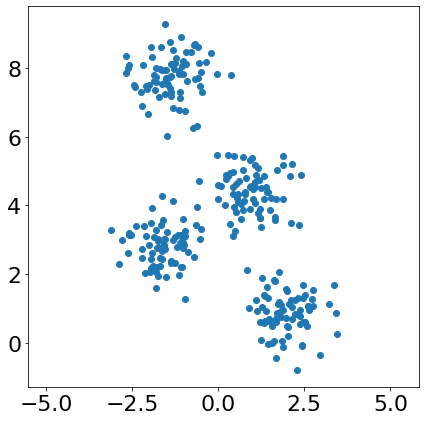

In [ ]:
#@slideshow fragment tags=remove_input
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=0.6)
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 7))
plt.axis("equal")
plt.scatter(X[:, 0], X[:, 1])
plt.show()

<!--@slideshow fragment-->
Can we find them automatically?

<!--@slideshow slide-->
## $k$-means algorithm

$k$-means algorithm computes $k$ cluster centers using so-called **expectation-maximization** approach.

1. Start with initial (random) cluster centers.
2. Update cluster centers, repeating 2 steps:
    1. Assign points to the nearest cluster center (**expectation** step).
    2. Set the centers to the average of points belonging to the cluster (**maximization** step).

<!--@slideshow slide-->
## Colab demo: $k$-means

In [ ]:
demo_kmeans(k=4)

In [ ]:
# try wrong number of cluster
demo_kmeans(k=5)

In [ ]:
enable_mathjax_in_cell()
quiz_kmeans()()

<!--@slideshow slide-->
Since we know true labels of texts, **in this lesson** we will evaluate quality of clustering using true labels.



In [ ]:
#@slideshow fragment
def estimate_clustering_quality(target, prediction):
    from itertools import combinations
    N = len(target)
    total_pairs = 0
    # we will count the ratio of "good" pairs of points
    good_pairs = 0
    for pair in combinations(range(N), 2):
        # NB: O(n**2) complexity!
        total_pairs += 1
        i, j = pair
        if (target[i] == target[j]) == (prediction[i] == prediction[j]):
            # a pair of points is "good" if and only if
            #   - either both points belong to the same cluster and have the same label
            #   - or points belong to different clusters and have different labels
            good_pairs += 1

    return good_pairs / total_pairs

<!--@slideshow slide-->
## Colab quiz 2

Evaluate quality of clustering.

In [ ]:
enable_mathjax_in_cell()
quiz_estimate_clustering_quality()()

<!--@slideshow slide-->
## Colab demo: $k$-means in `sklearn`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import numpy as np

categories = ("sci.space", "rec.sport.hockey", "comp.graphics")
fetch_params = dict(
    shuffle=True, random_state=1,
    remove=('headers', 'footers', 'quotes'),
    categories=categories
)
train_dataset = fetch_20newsgroups(subset="train", **fetch_params)
test_dataset = fetch_20newsgroups(subset="test", **fetch_params)

vec = TfidfVectorizer(stop_words="english")
vec.fit(train_dataset.data)
X_train = vec.transform(train_dataset.data)
X_test = vec.transform(test_dataset.data)

In [ ]:
# for this dataset we know the true number of classes, but in general we don't
n_clusters = len(categories)

0.7228165640119718

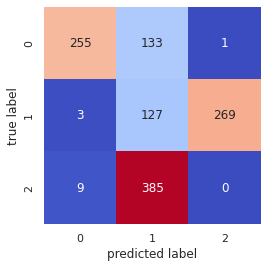

In [ ]:
# KMeans has standard fit/predict interface
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=20)
kmeans.fit(X_train)
predictions = kmeans.predict(X_test)
plot_confusion_matrix(test_dataset.target, predictions)
estimate_clustering_quality(test_dataset.target, predictions)

Compare clustering quality with random benchmark.

0.5557895671883216

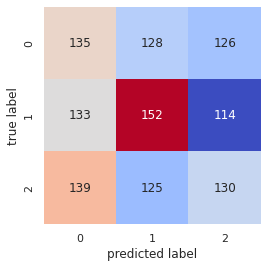

In [ ]:
import random
random.seed(0)
random_predictions = [random.randint(0, n_clusters - 1) for _ in test_dataset.target]
plot_confusion_matrix(test_dataset.target, random_predictions)
estimate_clustering_quality(test_dataset.target, random_predictions)

Compare with classification.


0.8967120410446853

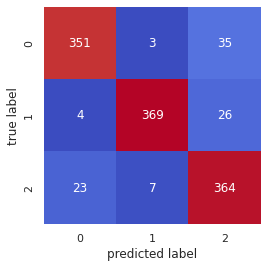

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(alpha=.0001, max_iter=50, penalty="l2", loss="log", random_state=0)
clf.fit(X_train, train_dataset.target)
plot_confusion_matrix(test_dataset.target, clf.predict(X_test))
estimate_clustering_quality(test_dataset.target, clf.predict(X_test))

<!--@slideshow slide-->
Let's do an experiment.

What are the largest components (words) for each centroid?

In [ ]:
#@slideshow fragment tags=remove_input
show_vectorizer_largest_components(vec, kmeans.cluster_centers_)

['software', '3d', 'mail', 'use', 'ftp', 'advance', 'need', 'hi', 'format',
 'looking', 'help', 'windows', 'does', 'program', 'know', 'image', 'file',
 'files', 'graphics', 'thanks']
['ve', 'year', 'long', 'shuttle', 'does', 'need', 'edu', 'earth', 'moon',
 'orbit', 'launch', 'people', 'time', 'know', 'think', 'nasa', 'don', 'like',
 'just', 'space']
['time', 'toronto', 'like', 'good', 'don', 'teams', 'leafs', 'detroit', 'win',
 'think', 'league', 'year', 'nhl', 'games', 'players', 'play', 'season',
 'hockey', 'team', 'game']


<!--@slideshow fragment-->
Is there the correspondence between largest components and true categories? Remember that the categories are ("sci.space", "rec.sport.hockey", "comp.graphics").


<!--@slideshow fragment-->
It is important that we found centroids (and their components) **without any information about true categories**.

<!--@slideshow slide-->
# Text classification

<!--@slideshow slide-->
## Metrics of classification
- Confusion matrix
- Precision
- Recall
- ROC-AUC

<!--@slideshow slide-->
## Confusion matrix
Q: The classifier has 99% accuracy and doesn't overfit. Is it good or bad?

In [ ]:
#@slideshow fragment

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

N_SAMPLES = 1000
X, y = make_classification(
    n_samples=N_SAMPLES,
    weights=(0.99, 0.01),
    n_features=100,
    random_state=1
)
print(len(y), sum(y))

y_pred = [0 for _ in range(N_SAMPLES)]
print(accuracy_score(y, y_pred))

1000 11
0.989


<!--@slideshow slide-->
The accuracy is bad for imbalanced datasets.
That's why we need to look carefully at two different types of errors:

- False negative: the predicted label is 0, the true label is 1
- False positive: the predicted label is 1, the true label is 0

The quality of classification is completely described by a *confusion matrix*:


In [ ]:
#@slideshow fragment
from sklearn.metrics import confusion_matrix

#  -------------------------------------------
# | True Negative  (TN) | False Positive (FP) |
# |-------------------------------------------|
# | False Negative (FN) | True Positive  (TP) |
#  -------------------------------------------
print(confusion_matrix(y, y_pred))

[[989   0]
 [ 11   0]]


In [ ]:
#@slideshow slide

y_true = [0,0,0,1,1,0]
y_pred = [0,1,1,0,1,0]
# TN (true=0, pred=0) = 2
# FP (true=0, pred=1) = 2
# FN (true=1, pred=0) = 1
# TP (true=1, pred=1) = 1
print(confusion_matrix(y_true, y_pred))

[[2 2]
 [1 1]]


<!--@slideshow slide-->

## Precision
The precision is, by definition:
$$
precision(y_{true}, y_{predicted}) = \dfrac{TP}{TP + FP}
$$

It answers the question "how frequently the positive predictions are actually positive?".

In [ ]:
#@slideshow fragment
from sklearn.metrics import precision_score

y_true = [0, 0, 1, 1, 1, 0]
y_pred = [0, 1, 1, 1, 1, 0]
print(precision_score(y_true, y_pred))

0.75


<!--@slideshow slide-->

## Recall
The recall is, by definition:
$$
recall(y_{true}, y_{predicted}) = \dfrac{TP}{TP+FN}
$$
It answers the question "how many positive examples does the classifier find?".

In [ ]:
#@slideshow fragment
from sklearn.metrics import recall_score

y_true = [0, 1, 1, 1, 1, 0]
y_pred = [0, 1, 1, 0, 0, 0]
print(recall_score(y_true, y_pred))

0.5


<!--@slideshow slide-->

## ROC-AUC score
Suppose that the classifier predicts $h(\mathbf{x}) \approx \Pr(y=1|\mathbf{x})$.
To get binary predictions, we put threshold somewhere.

- For each value of the threshold, we have its own *confusion matrix*.
- For each confusion matrix, we may compute
  - True Positive Rate (recall)
  $$
    TPR = \dfrac{TP}{TP+FN}
  $$
  - False Positive Rate
  $$
    FPR = \dfrac{FP}{FP+TN}
  $$
The dependence $TPR(FPR)$ is called ROC-curve (receiver operating characteristic curve).
Let us visualize it for several cases.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_tpr_fpr(y_true, y_pred):
  # we will collect tpr and fpr and plot them later
  tpr_list = []
  fpr_list = []
  
  # put the thresholds between all consecutive pairs of points
  y_pred_sorted = sorted(y_pred)
  thresholds = [0.5 * (y_pred_sorted[i] + y_pred_sorted[i+1]) for i in range(len(y_pred_sorted) - 1)]
  for threshold in thresholds:
    y_pred_thresholded = [int(p > threshold) for p in y_pred]
    # array([[1, 2], [3, 4]]).ravel() == array([1, 2, 3, 4])
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresholded).ravel()
    tpr_list.append(tp / (tp + fn))
    fpr_list.append(fp / (fp + tn))
  
  fig, ax = plt.subplots(1, 2, figsize=(20, 7))
  ax[0].plot(fpr_list, tpr_list)
  ax[0].set_xlabel('FPR')
  ax[0].set_ylabel('TPR')
  
  # plot positive and negative separately
  predictions_for_positive = [y_pred[i] for i in range(len(y_true)) if y_true[i] >  0]
  predictions_for_negative = [y_pred[i] for i in range(len(y_true)) if y_true[i] <= 0]
  
  ax[1].scatter(predictions_for_positive, [1.0 for _ in predictions_for_positive], color='b', label='positive')
  ax[1].scatter(predictions_for_negative, [0.5 for _ in predictions_for_negative], color='r', label='negative')
  ax[1].set_yticks([])
  ax[1].set_xlabel('prediction')
  ax[1].legend(loc="center left")
  plt.show()

<!--@slideshow slide-->
### 1. ROC-AUC for random predictions

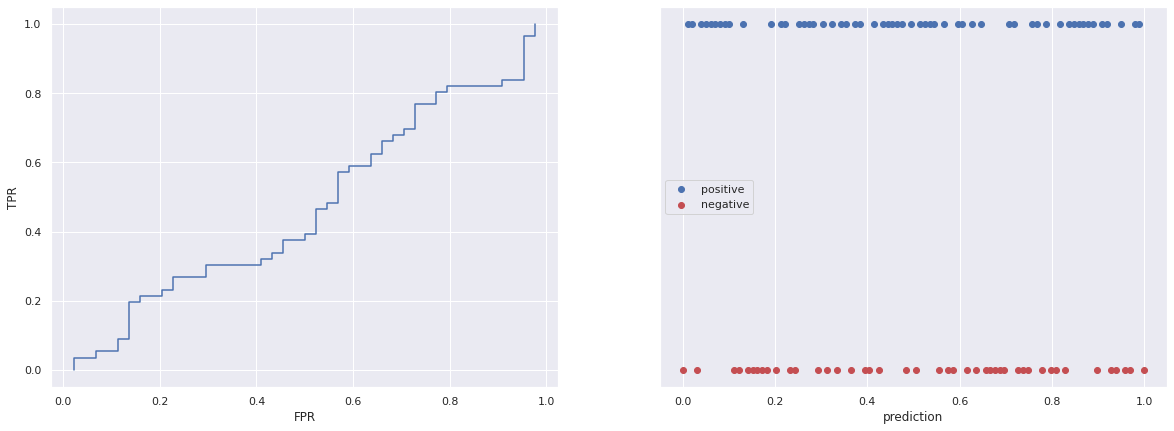

In [ ]:
#@slideshow fragment
import numpy as np
np.random.seed(0)

y_pred = np.linspace(0, 1, 100)
y_true = np.random.randint(2, size=100)
plot_tpr_fpr(y_true, y_pred)

The ROC-curve for random predictions is close to the diagonal.

<!--@slideshow slide-->
### 2. ROC-AUC for perfect predictions

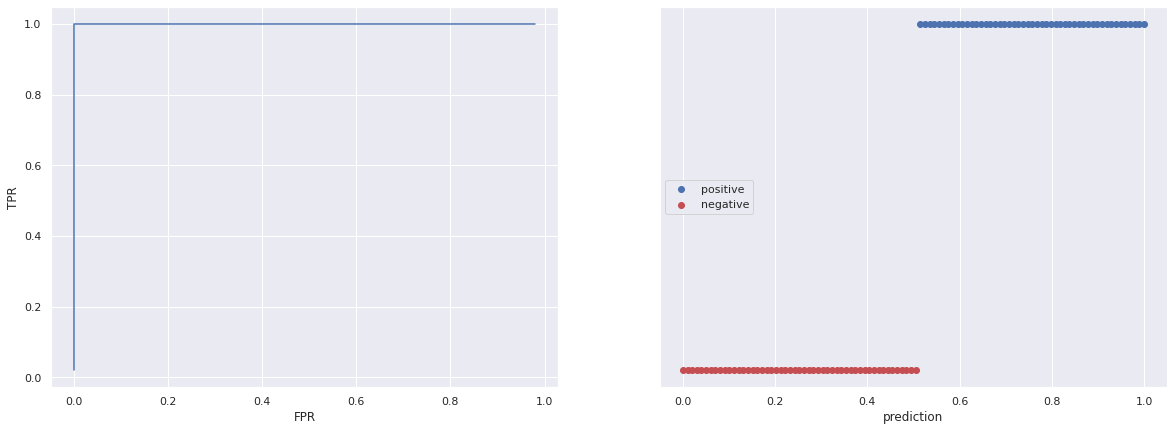

In [ ]:
#@slideshow fragment
import numpy as np

y_pred = np.linspace(0, 1, 100)
y_true = [int(i > 50) for i in range(100)]
plot_tpr_fpr(y_true, y_pred)

The ROC -curve for perfect predictions is a constant 1.

<!--@slideshow slide-->
### 3. ROC-AUC for "good" predictions

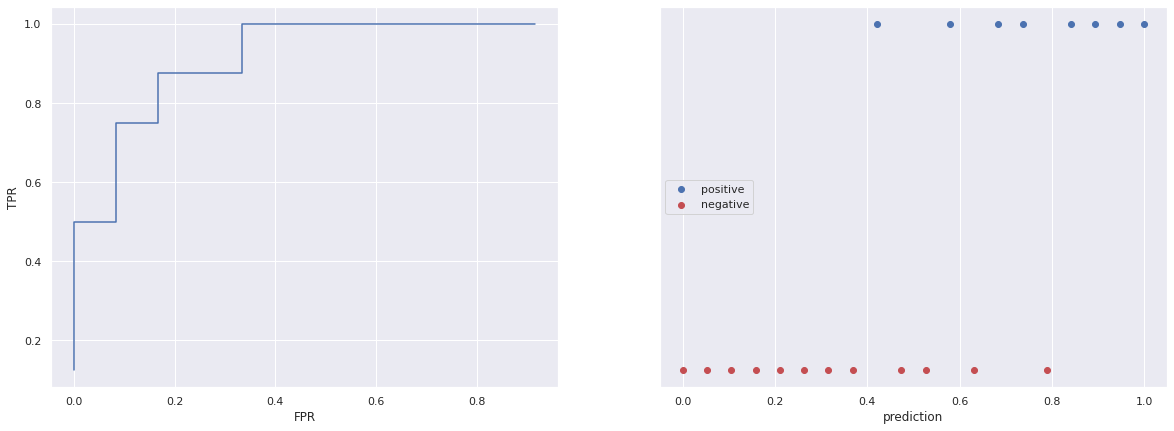

In [ ]:
#@slideshow fragment
y_pred = np.linspace(0, 1, 20)
y_true = [0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,1,1,]
plot_tpr_fpr(y_true, y_pred)

The ROC-curve for good predictions is concave.

<!--@slideshow slide-->
Instead of the full ROC-curve, we may consider only the *area under the curve* -- ROC-AUC.

- ROC-AUC $\approx$ 0.5 for random predictions
- ROC-AUC = 1 for perfect predictions
- Greater is better

**Interpretation**: the probability that the model ranks a random positive example more highly than a random negative example.

<!--@slideshow slide-->
## Colab demo: TF-IDF vectors as features

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = ('sci.crypt', 'sci.electronics', 'sci.med', 'sci.space')
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', remove=remove, categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=remove, categories=categories)

y_train = (newsgroups_train.target == 3).astype(int)  # 3 is "space"
y_test = (newsgroups_test.target == 3).astype(int)

print("Data:\n", newsgroups_train.data[31])
print("---")
print("Target:", y_test[31])

Data:
 I've got two lines coming into my apartment. Two different telephone numbers.
When I ordered the second line installed, instead of bringing out another 4
wire bundle, the telco just connected up to my yellow and black wires. So I
have one line on red & green and the other on yellow & black.

Today I was monitoring the voltage on both lines. I had a voltmeter across
the red and green and read back 52 volts. I then lifted up the receiver on my
second line.(black & yellow wires) The voltage dropped to 31 volts on the first
line. (red & green wires) I repeated this experiment with the second
line(monitoring black & yellow and lifting the handset off the cradle on the
red and green line.) It also dropped to 31 volts. 

Why is this ? I thought these were separate lines.

Next I went to the 66 block and disconnected the blue and white lines coming in
from the telco cable. I then disconnected all the phones in my apartment and
went back to the 66 block and did some resistance measuremen

So far in our demonstrations we compared classifiers on test data.
Effectively it turned test data into validation data.

Now we will be more careful and choose best vectorizer using cross-validation. To do so, we will implement our own "wrapper" and use it in Pipeline.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class AnyVectorizer(TransformerMixin, BaseEstimator):
    def __init__(self, vectorizer="count"):
        if vectorizer not in ["count", "tfidf"]:
            raise ValueError(f'Wrong vectorizer: {vectorizer}')
        self.vectorizer = vectorizer

    def fit(self, X, y=None):
        if self.vectorizer == "count":
            self.vec_ = CountVectorizer()
        elif self.vectorizer == "tfidf":
            self.vec_ = TfidfVectorizer()
        self.vec_.fit(X)
        return self
    
    def transform(self, X):
        return self.vec_.transform(X)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

pipe = Pipeline([
    ('vec', AnyVectorizer()),
    ('clf', SGDClassifier(loss='log', penalty='elasticnet', random_state=0)),
])

# sample uniformly in log scale
params_distributions = {
    'clf__l1_ratio': uniform(0.1, 1),  # more l1 = more sparsity
    'vec__vectorizer': ["count", "tfidf"],
}

# RandomizedSearchCV is a 'wrapper' which accepts the initial classifier (ElasticNet())
# and distribution of parameters to sample from
randomized_search_clf = RandomizedSearchCV(
    pipe,
    params_distributions,
    n_iter=20,
    cv=3,
    random_state=0,
)
randomized_search_clf.fit(newsgroups_train.data, y_train)
randomized_search_clf.best_params_

{'clf__l1_ratio': 0.9700872583584363, 'vec__vectorizer': 'tfidf'}

In [ ]:
# `display_cv_results` is an auxiliary function I implemented for the demonstration
display_cv_results(randomized_search_clf)

,mean_test_score,param_clf__l1_ratio,param_vec__vectorizer
0,0.899284,0.970087,tfidf
1,0.898019,0.68202,tfidf
2,0.898019,0.668045,tfidf
3,0.897598,0.944266,tfidf
4,0.897177,0.899159,tfidf
5,0.896755,0.878157,tfidf
6,0.895491,0.648814,tfidf
7,0.895070,0.644883,tfidf
8,0.894648,0.620477,tfidf
9,0.892962,0.205908,tfidf


Now we can reliably evaluate accuracy on test set

In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy on the training dataset: {}".format(accuracy_score(randomized_search_clf.predict(newsgroups_train.data), y_train)))
print("Accuracy on the testing dataset: {}".format(accuracy_score(randomized_search_clf.predict(newsgroups_test.data), y_test)))

Accuracy on the training dataset: 0.956173619890434
Accuracy on the testing dataset: 0.8917036098796707


<!--@slideshow slide-->
## Colab demo: Text features in CatBoost

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


We can tell CatBoost that a column contains a text feature.
In the newsgroups dataset, there is only a single text feature.

In [ ]:
import catboost as cb
clf = cb.CatBoostClassifier(iterations=100)  # no hyperparameters tuning, just short demo

learn_pool = cb.Pool(newsgroups_train.data, y_train, text_features=[0])
clf.fit(learn_pool)

In [ ]:
test_pool = cb.Pool(newsgroups_test.data, y_test, text_features=[0])
print("Accuracy on the training dataset: {}".format(accuracy_score(clf.predict(learn_pool), y_train)))
print("Accuracy on the testing dataset: {}".format(accuracy_score(clf.predict(test_pool), y_test)))

Accuracy on the training dataset: 0.9599662873999157
Accuracy on the testing dataset: 0.9081697276757441


### How text features in CatBoost work
CatBoost handles text features in the following steps

#### Tokenization
It just splits by white space (like `str.split()` in Python). If you want to add custom tokenization (and lemmatization), you need to **pre-process the text manually** (for example, using `spaCy`).


#### Dictionary creation

Works much like `vocabulary_` in sklearn vectorizers (maps tokens into fixed positions).

One of the simplest text to vector encoding technique is **Bag of words (BoW)**.

##### Bag of words algorithm

The algorithm takes in a dictionary and a text.<br>
During the algorithm text $x = (a_0, a_1, ..., a_k)$ converted into vector $\tilde x = (b_0, b_1, ..., b_F)$,<br> where $b_i$ is number of occurences word with id=$i$ from dictionary into text $x$.

##### Looking at sequences of letters / words

Let's look at the example: texts 'The cat defeated the mouse' and 'Army of mice defeated the cat :('<br>
Simplifying it we have three tokens in each sentence 'cat defeat mouse' and 'mouse defeat cat'.<br>
After applying BoW we get two equal vectors with the opposite meaning:

| cat | mouse | defeat |
|-----|-------|--------|
| 1   | 1     | 1      |
| 1   | 1     | 1      |

How to distinguish them?
Lets add sequences of words as a single tokens into our dictionary:

| cat | mouse | defeat | cat_defeat | mouse_defeat | defeat_cat | defeat_mouse |
|-----|-------|--------|------------|--------------|------------|--------------|
| 1   | 1     | 1      | 1          | 0            | 0          | 1            |
| 1   | 1     | 1      | 0          | 1            | 1          | 0            |

**N-gram** is a continguous sequence of $n$ items from a given sample of text or speech (Wikipedia).<br>
In example above Bi-gram (Bigram) = 2-gram of words.

##### Dictionaries in CatBoost

To specify which type of dictionary to create in CatBoost you need to pass `dictionaries` parameter. This parameter specifies all dictionaries that are computed during text preprocessing procedure.

Dictionaries parameters specified as list of strings, each string is a description of dictionary in the following format:<br>
``'DictionaryName:[Param1=Value1,[Param2=Value2]]'``

Here is a list of all parameters:<br>
``min_token_occurrence`` -- number; minimal token occurence to enter to dictionary<br>
``max_dict_size`` -- number; maximum dictionary size<br>
``token_level_type`` -- string: ``Word`` or ``Letter``; use letter or word tokens<br>
``gram_order`` -- number; build n-gram dictionary.

**Important hyperparameters**

``min_token_occurrence`` -- parameter can be very useful for filtering too rare tokens, this helps to avoid overfitting<br>
``max_dict_size`` -- parameter can help to control the size of model

In [ ]:
import catboost as cb

clf = cb.CatBoostClassifier(
    iterations=100,
    dictionaries=[
        {'dictionary_id': 'Word', 'min_token_occurence': '5'},
        {'dictionary_id': 'BiGram', 'gram_order': '2'},
    ],
)

learn_pool = cb.Pool(newsgroups_train.data, y_train, text_features=[0])
clf.fit(learn_pool)

In [ ]:
from sklearn.metrics import accuracy_score
test_pool = cb.Pool(newsgroups_test.data, y_test, text_features=[0])
print("Accuracy on the training dataset: {}".format(accuracy_score(clf.predict(learn_pool), y_train)))
print("Accuracy on the testing dataset: {}".format(accuracy_score(clf.predict(test_pool), y_test)))

Accuracy on the training dataset: 0.9599662873999157
Accuracy on the testing dataset: 0.9081697276757441


#### Estimating numerical features

Numerical features are calculated based on the source tokenized.

The default method is Bag Of Words.

Other methods include NaiveBayes and BM25, we will not cover them.

### Solve Quora Question Pairs Challenge with CatBoost

In [ ]:
import pandas as pd

df = pd.read_csv("harbour-space-text-mining-course/datasets/quora_question_pairs/train.csv")
print(f"Total samples: {df.shape[0]}")
# select a subset of rows to speed up the demonstration
df = df.head(20000)
# `is_duplicate` shows whether `question1` and `question2` are duplicates
df[["question1", "question2", "is_duplicate"]].head(10)

Total samples: 404290


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df.fillna("."), test_size=0.5, shuffle=True, random_state=0)

In [ ]:
quora_train_pool = cb.Pool(
    df_train[["question1", "question2"]],
    df_train.is_duplicate,
    text_features=["question1", "question2"]
)
quora_test_pool = cb.Pool(
    df_test[["question1", "question2"]],
    df_test.is_duplicate,
    text_features=["question1", "question2"]
)

In [ ]:
clf = cb.CatBoostClassifier(
    iterations=300,
    dictionaries=[
        {'dictionary_id': 'Word', 'min_token_occurence': '5'},
        {'dictionary_id': 'BiGram', 'gram_order': '2'},
    ],
)

clf.fit(quora_train_pool)

Learning rate set to 0.083064
0:	learn: 0.6802212	total: 1.03s	remaining: 5m 8s
1:	learn: 0.6688026	total: 2.08s	remaining: 5m 9s
2:	learn: 0.6582210	total: 2.97s	remaining: 4m 53s
3:	learn: 0.6495029	total: 3.8s	remaining: 4m 41s
4:	learn: 0.6428457	total: 4.79s	remaining: 4m 42s
5:	learn: 0.6356618	total: 5.62s	remaining: 4m 35s
6:	learn: 0.6297749	total: 6.51s	remaining: 4m 32s
7:	learn: 0.6249717	total: 7.49s	remaining: 4m 33s
8:	learn: 0.6207894	total: 8.48s	remaining: 4m 34s
9:	learn: 0.6162974	total: 9.64s	remaining: 4m 39s
10:	learn: 0.6133653	total: 10.4s	remaining: 4m 34s
11:	learn: 0.6106988	total: 11.4s	remaining: 4m 33s
12:	learn: 0.6085977	total: 12.5s	remaining: 4m 35s
13:	learn: 0.6063706	total: 13.3s	remaining: 4m 31s
14:	learn: 0.6038164	total: 14.2s	remaining: 4m 30s
15:	learn: 0.6012020	total: 15.2s	remaining: 4m 29s
16:	learn: 0.5986308	total: 16.5s	remaining: 4m 34s
17:	learn: 0.5972498	total: 17.3s	remaining: 4m 30s
18:	learn: 0.5952013	total: 18.2s	remaining: 4m

In [ ]:
from sklearn.metrics import roc_auc_score

print("ROC AUC:", roc_auc_score(df_test.is_duplicate, clf.predict_proba(quora_test_pool)[:,1]))

ROC AUC: 0.7765275749118012


## In-class practice

Pre-process texts in the dataset QuoraQuestionPairs using spaCy,  train CatBoost and evaluate accuracy on test.

In [ ]:
# the code for your reference
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "tok2vec"])

def extract_lemmas_q1(r):
    return " ".join([
        token.lemma_
        for token in nlp(r['question1'])
    ])

df_train['question1_lemmas'] = df_train.apply(extract_lemmas_q1, axis=1)
# df_train['question2_lemmas'] = ... YOUR CODE HERE
# YOUR CODE HERE: the same code for test_df

# then train CatBoost using 'question1_lemmas' and 'question2_lemmas'
# apply on the test dataset

In [ ]:
# DEBUG
def extract_lemmas(column):
    def extract_lemmas_col(r):
        return " ".join([
            token.lemma_
            for token in nlp(r[column])
        ])
    return extract_lemmas_col

df_train.head().apply(extract_lemmas('question1'), axis=1)

19879               what is the least painful way to die ?
7502     is free higher education in germany sustainable ?
2745     what is the effect of demonetization of 500 an...
12494    is islamic culture friendly with science ficti...
6906      which are the top 50 business schools in india ?
dtype: object

# Home Assignment 7

In this assignment you are given the following dataset:

In [13]:
import pandas as pd
df = pd.read_csv("harbour-space-text-mining-course/datasets/content_classification.csv", header=0, names=["text", "label"])
df.head()

,text,label
0,I meditated last night.,leisure
1,My grandmother start to walk from the bed afte...,affection
2,I picked my daughter up from the airport and w...,bonding
3,when i received flowers from my best friend,bonding
4,I went shopping,leisure


## Exercise 1 (1 point)
In this dataset, each text has a human-readable label instead of numeric label. You need to convert the labels into a vector of numbers (the vector $y$ in our notation). Use `sklearn.preprocessing.LabelEncoder` (see the example below).

In [ ]:
# example of LabelEncoder usage
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
print(f"le.classes_: {le.classes_}")
print(le.transform(["tokyo", "tokyo", "paris"]))
print(list(le.inverse_transform([2, 2, 1])))

le.classes_: ['amsterdam' 'paris' 'tokyo']
[2 2 1]
['tokyo', 'tokyo', 'paris']


In [5]:
from sklearn.preprocessing import LabelEncoder

# YOUR CODE HERE: create label encoder
le = LabelEncoder()

# YOUR CODE HERE: fit label encoder
le.fit(df['label'])
y = le.transform(df['label'])# YOUR CODE HERE: transform the labels

## Exercise 2 (2 points)

Train `SGDClassifier` on TF-IDF features (use `TdIdfVectorizer`). Split into train and test (use 20% for test). Choose hyperparameters using random search and evaluate accuracy on train and test.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'loss': ['hinge', 'log']}

clf = SGDClassifier()
search = RandomizedSearchCV(clf, param_grid, n_iter=5)

search.fit(X_train, y_train)
best_params = search.best_params_

train_acc = accuracy_score(y_train, search.predict(X_train))
test_acc = accuracy_score(y_test, search.predict(X_test))

print('Best hyperparameters:', best_params)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)


Best hyperparameters: {'loss': 'hinge', 'alpha': 0.001}
Train accuracy: 0.805528134254689
Test accuracy: 0.7603632056849585


## Exercise 3 (3 points)
Train CatBooseClassifier on text features. You may use default hyperparameters of CatBoost. Use the same train/test split as in Exercise 2 to evaluate quality.

In [3]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.7 MB/s eta 0:00:00


In [41]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import catboost as cb
df_train, df_test= train_test_split(df.fillna("."), test_size=0.2,shuffle=True, random_state=0)


In [ ]:
clf = cb.CatBoostClassifier(iterations=100) 
learn_pool = cb.Pool(df_train.text, df_train.label,  text_features=[0])
clf.fit(learn_pool)

In [55]:
df_train.columns

Index(['text', 'label'], dtype='object')

In [56]:
test_pool = cb.Pool(df_test[['text']], df_test.label,  text_features=[0])


In [57]:
print("Accuracy on the training dataset: {}".format(accuracy_score(clf.predict(learn_pool), df_train.label)))
print("Accuracy on the testing dataset: {}".format(accuracy_score(clf.predict(test_pool), df_test.label)))

Accuracy on the training dataset: 0.88213228035538
Accuracy on the testing dataset: 0.7812870114488748


**The accuracy has increased when Catboost is used**